In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [10]:
# Define paths to data files
base_path = "/kaggle/input/kuairec-content-based"
interactions_big_path = os.path.join(base_path, "big_matrix.csv")
interactions_small_path = os.path.join(base_path, "small_matrix.csv")
item_features_path = os.path.join(base_path, "item_categories.csv")

interactions_big_df = pd.read_csv(interactions_big_path)
interactions_small_df = pd.read_csv(interactions_small_path)
item_features_df = pd.read_csv(item_features_path)

print(f"Interactions shape: {interactions_big_df.shape}")
print(f"Interactions small shape: {interactions_small_df.shape}")
print(f"Item features shape: {item_features_df.shape}")

Interactions shape: (12530806, 8)
Interactions small shape: (4676570, 8)
Item features shape: (10728, 2)


In [11]:
interactions_big_df.drop(columns=["date", 'time'], inplace=True)
interactions_big_df.rename(columns={'user_id': 'userId', 'video_id': 'itemId'}, inplace=True)
interactions_small_df.drop(columns=["date", 'time'], inplace=True)
interactions_small_df.rename(columns={'user_id': 'userId', 'video_id': 'itemId'}, inplace=True)

item_features_df["feat"] = item_features_df["feat"].map(eval)
all_categories = [i for i in range(31)]

items_preproccesed = pd.DataFrame(index=item_features_df.index)

for category in sorted(all_categories):
    column_name = category
    items_preproccesed[column_name] = item_features_df['feat'].apply(lambda x: 1 if category in x else 0)
items_preproccesed['video_id'] = item_features_df["video_id"]
items_preproccesed.drop(columns=[14, 23, 27, 21, 0, 30, 22, 24, 29], inplace=True)
items_preproccesed.rename(columns={'video_id':'itemId'}, inplace=True)

items_preproccesed.set_index('itemId', inplace=True)

In [12]:
train_data = pd.merge(interactions_big_df, items_preproccesed, on='itemId', how='left')
test_data = pd.merge(interactions_small_df, items_preproccesed, on='itemId', how='left')

In [13]:
train_data[train_data['watch_ratio'] > 5] = 5
test_data[test_data['watch_ratio'] > 5] = 5

In [23]:
class ContentBasedRecommender:
    def __init__(self, item_features_df, params=None):
        self.item_features_df = item_features_df
        self.model = None
        self.user_profiles = {}
        
        self.params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'eta': 0.05,
            'max_depth': 10,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_weight': 1,
            'gamma': 0.1
        }
        
        if params:
            self.params.update(params)
            
    def fit(self, train_data, feature_cols=None):
        """Train an XGBoost model for content-based recommendations."""
        
        if feature_cols is None:
            feature_cols = train_data.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
            feature_cols = [col for col in feature_cols if col not in ['userId', 'itemId', 'watch_ratio']]
        
        print(f"Using features: {feature_cols}")
        
        print("Training XGBoost model...")
        X = train_data[feature_cols].values
        y = train_data['watch_ratio'].values
        
        X_train, X_val = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
        y_train, y_val = y[:int(0.8*len(y))], y[int(0.8*len(y)):]
        
        dtrain_final = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        self.model = xgb.train(
            self.params, 
            dtrain_final, 
            num_boost_round=200,
            evals=[(dtrain_final, 'train'),(dval, 'validation')],
            early_stopping_rounds=50,
            verbose_eval=20
        )
        
        print("Creating user profiles...")
        for user_id, group in train_data.groupby('userId'):
            self.user_profiles[user_id] = group[feature_cols].mean().values
            
        return self

    def evaluate(self, test_data, feature_cols=None, k=10, relevance_threshold=0.8):
        if feature_cols is None:
            feature_cols = test_data.columns.tolist()
            feature_cols = [col for col in feature_cols if col not in ['userId', 'itemId', 'watch_ratio']]
        
        print("Generating predictions for evaluation...")
        X_test = test_data[feature_cols].values
        y_true = test_data['watch_ratio'].values
        
        dtest = xgb.DMatrix(X_test)
        
        test_data['prediction'] = self.model.predict(dtest)
        
        rmse = np.sqrt(mean_squared_error(y_true, test_data['prediction']))
        mae = np.mean(np.abs(y_true - test_data['prediction']))
        
        print(f"\nCalculating ranking metrics at k={k}...")
        
        precision = self._calculate_precision(test_data, k=k)
        
        hit_rate = self._calculate_hit_rate(test_data, k=k, relevance_threshold=relevance_threshold)
        
        mrr = self._calculate_mrr(test_data, k=k, relevance_threshold=relevance_threshold)
        ndcg = self._calculate_ndcg(test_data, k=k, relevance_threshold=relevance_threshold)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(y_true, test_data['prediction'], alpha=0.3)
        plt.xlabel('Actual Watch Ratio')
        plt.ylabel('Predicted Watch Ratio')
        plt.title('Actual vs Predicted Watch Ratio')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"Precision@{k}: {precision:.4f}")
        print(f"Hit Rate@{k}: {hit_rate:.4f}")
        print(f"MRR@{k}: {mrr:.4f}")
        print(f"NDCG@{k}: {ndcg:.4f}")

        
        return {
            "rmse": rmse,
            "mae": mae,
            "precision": precision,
            "hit_rate": hit_rate,
            "mrr": mrr,
            "ndcg": ndcg
        }

    def _calculate_precision(self, test_data, k=10):
        """Calculate Precision@k."""
        top_k_preds = (
            test_data.groupby('userId')
            .apply(lambda x: x.nlargest(k, 'prediction'))
            .reset_index(drop=True)
        )
        
        top_k_actual = (
            test_data.groupby('userId')
            .apply(lambda x: x.nlargest(k, 'watch_ratio'))
            .reset_index(drop=True)
        )
        
        joined_items = pd.merge(
            top_k_preds[['userId', 'itemId']],
            top_k_actual[['userId', 'itemId']],
            on=['userId', 'itemId'],
            how='inner'
        )
        
        precision = len(joined_items) / len(top_k_preds) if len(top_k_preds) > 0 else 0
        return precision

    def _calculate_hit_rate(self, test_data, k=10, relevance_threshold=0.8):
        """Calculate Hit Rate@k."""
        top_k_preds = (
            test_data.groupby('userId')
            .apply(lambda x: x.nlargest(k, 'prediction'))
            .reset_index(drop=True)[['userId', 'itemId']]
        )
        
        relevant_items = test_data[test_data['watch_ratio'] >= relevance_threshold][['userId', 'itemId']]
        
        users_with_relevant_items = relevant_items['userId'].unique()
        num_users_with_relevant_items = len(users_with_relevant_items)
        
        if num_users_with_relevant_items == 0:
            return 0.0
        
        hits = pd.merge(
            top_k_preds,
            relevant_items,
            on=['userId', 'itemId'],
            how='inner'
        )
        
        users_with_hits = hits['userId'].unique()
        users_with_hits_count = len(users_with_hits)
        
        hit_rate = users_with_hits_count / num_users_with_relevant_items
        return hit_rate

    def _calculate_mrr(self, test_data, k=10, relevance_threshold=0.8):
        """Calculate MRR@k."""
        ranked_preds = []
        for user_id, group in test_data.groupby('userId'):
            sorted_group = group.sort_values('prediction', ascending=False).head(k)
            sorted_group['rank'] = range(1, len(sorted_group) + 1)
            ranked_preds.append(sorted_group)
        
        if len(ranked_preds) == 0:
            return 0.0
        
        ranked_preds_df = pd.concat(ranked_preds, ignore_index=True)
        
        relevant_items = test_data[test_data['watch_ratio'] >= relevance_threshold][['userId', 'itemId']]
        
        users_with_relevant_items = relevant_items['userId'].unique()
        num_users_with_relevant_items = len(users_with_relevant_items)
        
        if num_users_with_relevant_items == 0:
            return 0.0
        
        hits_with_rank = pd.merge(
            ranked_preds_df[['userId', 'itemId', 'rank']],
            relevant_items,
            on=['userId', 'itemId'],
            how='inner'
        )
        
        if len(hits_with_rank) > 0:
            first_hit_per_user = hits_with_rank.groupby('userId')['rank'].min().reset_index()
            first_hit_per_user['reciprocal_rank'] = 1 / first_hit_per_user['rank']
            total_rr = first_hit_per_user['reciprocal_rank'].sum()
        else:
            total_rr = 0
        
        mrr = total_rr / num_users_with_relevant_items
        return mrr
        
    def _calculate_ndcg(self, test_data, k=10, relevance_threshold=0.8):
        all_user_ndcgs = []

        for user_id, group in tqdm(test_data.groupby('userId'), desc="Calculating NDCG"):
            # Get top-k recommendations
            top_k_recs = group.sort_values('prediction', ascending=False).head(k)
            
            # Calculate DCG
            dcg = 0
            for i, row in enumerate(top_k_recs.itertuples()):
                # Relevance is 1 if watch_ratio >= threshold, else 0
                relevance = 1 if row.watch_ratio >= relevance_threshold else 0
                dcg += relevance / np.log2(i + 2)  # i+2 because rank starts from 1, log2(1+1)
            
            # Get top-k actual items (for IDCG)
            top_k_actual = group.sort_values('watch_ratio', ascending=False).head(k)
            
            # Calculate IDCG
            idcg = 0
            for i, row in enumerate(top_k_actual.itertuples()):
                relevance = 1 if row.watch_ratio >= relevance_threshold else 0
                idcg += relevance / np.log2(i + 2)
            
            if idcg == 0:
                user_ndcg = 0  # Or handle as per your preference, e.g., skip user
            else:
                user_ndcg = dcg / idcg
            
            all_user_ndcgs.append(user_ndcg)
            
        return np.mean(all_user_ndcgs) if all_user_ndcgs else 0.0

In [15]:
train_data.drop(columns=['timestamp'], inplace=True)

In [24]:
recommender = ContentBasedRecommender(item_features_df)
recommender.fit(train_data, feature_cols=items_preproccesed.columns.tolist())

Using features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 25, 26, 28]
Training XGBoost model...
[0]	train-rmse:0.80645	validation-rmse:0.80972
[20]	train-rmse:0.71699	validation-rmse:0.71806
[40]	train-rmse:0.70308	validation-rmse:0.70382
[60]	train-rmse:0.70085	validation-rmse:0.70155
[80]	train-rmse:0.70043	validation-rmse:0.70113
[100]	train-rmse:0.70018	validation-rmse:0.70089
[120]	train-rmse:0.70000	validation-rmse:0.70071
[140]	train-rmse:0.69992	validation-rmse:0.70064
[160]	train-rmse:0.69988	validation-rmse:0.70060
[180]	train-rmse:0.69985	validation-rmse:0.70058
[199]	train-rmse:0.69982	validation-rmse:0.70055
Creating user profiles...


Generating predictions for evaluation...

Calculating ranking metrics at k=100...


/tmp/ipykernel_35/627287527.py:110: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(k, 'prediction'))
/tmp/ipykernel_35/627287527.py:116: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(k, 'watch_ratio'))
/tmp/ipykernel_35/627287527.py:134: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a fu

Calculating NDCG:   0%|          | 0/1412 [00:00<?, ?it/s]

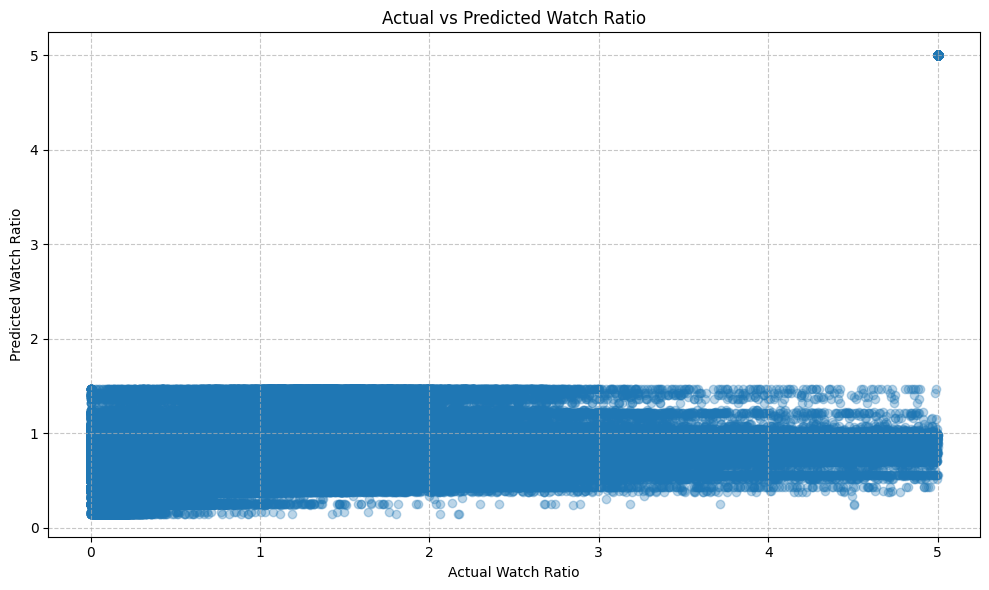

RMSE: 0.5748
MAE: 0.4073
Precision@100: 0.1311
Hit Rate@100: 1.0000
MRR@100: 0.9222
NDCG@100: 0.6813


In [26]:
metrics = recommender.evaluate(
    test_data, 
    feature_cols=items_preproccesed.columns.tolist(),
    k=100,                   
    relevance_threshold=0.8 
)

<Figure size 1200x600 with 0 Axes>

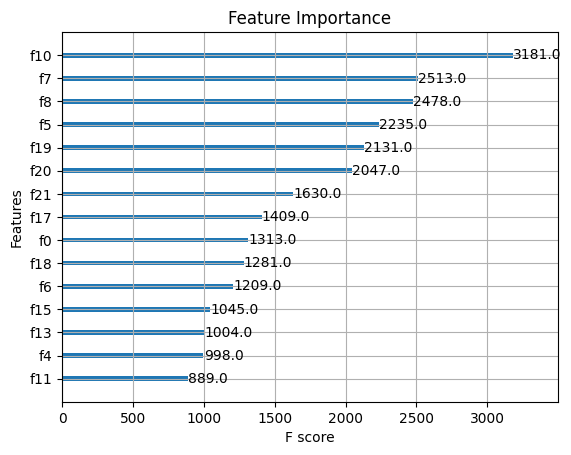

In [18]:
plt.figure(figsize=(12, 6))
xgb.plot_importance(recommender.model, max_num_features=15)
plt.title('Feature Importance')
plt.show()